In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import time
import h5py
import os,sys
import numpy as np
import matplotlib.pyplot as plt

In [3]:
DSPACK_HOME=os.environ.get("DSPACK_HOME")
if DSPACK_HOME not in sys.path:
    sys.path.append(DSPACK_HOME)

In [4]:
import scripts.fsystem
import scripts.statistics

In [5]:
workdir = "/reg/data/ana03/scratch/zhensu/Experiment/ICH/20201225/"
dnames = ["WT-1", "WT-2", "WT-3", "G150A-1", "G150A-2", "G150A-3", "G150T-1", "G150T-2", "G150T-3"]

In [7]:
stats = {}
for dname in dnames:
    stats[dname] = {}
    path_dsdata = "%s/data/%s/standard_clean_data_scale_profile_with_pca_map1.dsdata"%(workdir,dname)
    path_volume = scripts.fsystem.H5manager.reader(path_dsdata,"merge_volume")
    with h5py.File(path_volume,"r") as f:
        weight = f["weight"][()]
        volume = f["volume"][()]
        volume_backg_sub = f["volume_backg_sub"][()]
        volume_backg_sub_laue_sym = f["volume_backg_sub_laue_sym"][()]
        volume_backg_sub_friedel_sym = f["volume_backg_sub_friedel_sym"][()]
        vmask = (weight>=4).astype(int)
        
    """
    path_image = scripts.fsystem.H5manager.reader(path_dsdata,"image_file")[0]
    with h5py.File(path_image, "r") as f:
        lattice_constant = f["lattice_constant_A_deg"].value
    """
    path_pdb = scripts.fsystem.H5manager.reader(path_dsdata,"pdb_refmac5")
    lattice_constant = scripts.statistics.get_pdb_lattice_from_file(path_pdb)[:6]
    
        
    # Get CC Friedel
    volume_backg_sub[vmask==0] = -1024
    volume_backg_sub_friedel_sym[vmask==0] = -1024
    # 1./np.array(upper_res_Ainv), 1./np.array(floor_res_Ainv), np.array(corr), np.array(number_value)
    max_res_A, min_res_A, corr, number = scripts.volume.correlation(volume_backg_sub_friedel_sym, volume_backg_sub, \
                                                                lattice_constant_A_deg=lattice_constant, \
                                                                res_shell_step_Ainv=None, \
                                                                num_res_shell=15, res_cut_off_high_A=1.4, \
                                                                res_cut_off_low_A=50, num_ref_uniform=True, \
                                                                vmin = -100, vmax=1000)
    ave_res_invA = (1./max_res_A + 1./min_res_A)/2.
    ave_res_invA = ave_res_invA[:-1]
    ccfriedel = corr[:-1]
    stats[dname]["ccfriedel"] = (ave_res_invA, ccfriedel)
    
    # Get CC Laue
    volume_backg_sub[vmask==0] = -1024
    volume_backg_sub_laue_sym[vmask==0] = -1024
    max_res_A, min_res_A, corr, number = scripts.volume.correlation(volume_backg_sub_laue_sym, volume_backg_sub, \
                                                                lattice_constant_A_deg=lattice_constant, \
                                                                res_shell_step_Ainv=None, \
                                                                num_res_shell=15, res_cut_off_high_A=1.4, \
                                                                res_cut_off_low_A=50, num_ref_uniform=True, \
                                                                vmin = -100, vmax=1000)
    ave_res_invA = (1./max_res_A + 1./min_res_A)/2.
    ave_res_invA = ave_res_invA[:-1]
    cclaue = corr[:-1]
    stats[dname]["cclaue"] = (ave_res_invA, cclaue)
    
    # Get Completeness
    path_phenix = scripts.fsystem.H5manager.reader(path_dsdata,"phenix_merge_stats")
    with h5py.File(path_phenix,"r") as f:
        phenix_rmax_A_curve = f["phenix_rmax_A_curve"][()]
        phenix_rmin_A_curve = f["phenix_rmin_A_curve"][()]
        res_curve_invA = (1./phenix_rmax_A_curve + 1./phenix_rmin_A_curve)/2.
        stats[dname]["cc12"] = (res_curve_invA, f["phenix_cc12_curve"][()])
        stats[dname]["completeness"] = (res_curve_invA, f["phenix_completeness_curve"][()])

In [8]:
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple",\
          "tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"]
resolution_A = np.around(1./np.linspace(0.1,1./1.4,5),1)

dpi =  467


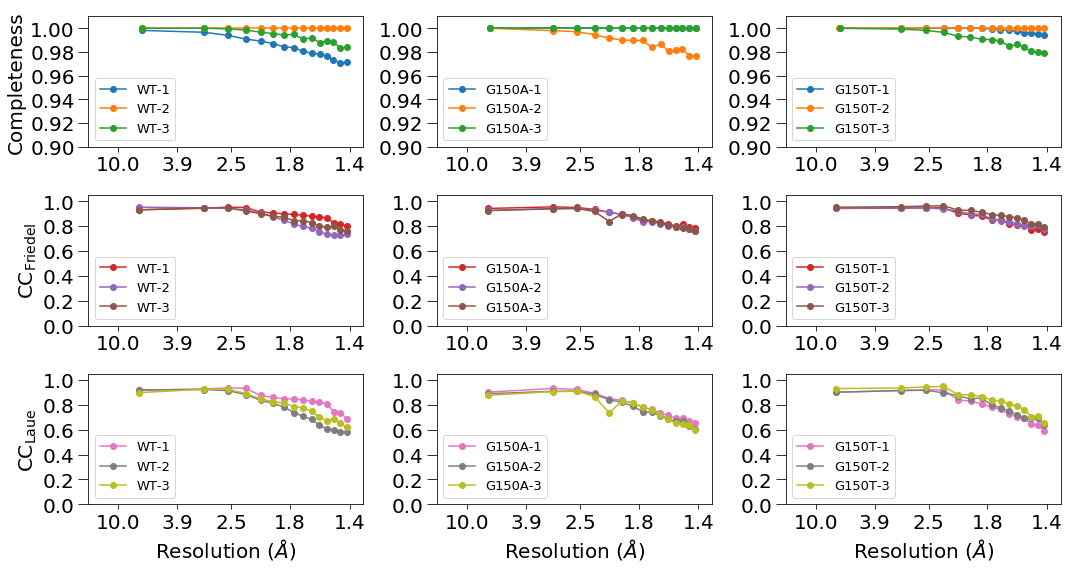

In [9]:
plt.figure(figsize=(15,8))

########################################## completeness 
plt.subplot(3,3,1)
for idx, dname in enumerate(dnames[0:3]):
    plt.plot(10*stats[dname]["completeness"][0], stats[dname]["completeness"][1]/100., "-o",label=dname,c=colors[idx])
plt.legend(loc=3,fontsize=13)
plt.xlim(0.2,7.5)
plt.ylim(0.9,1.01)
plt.ylabel("Completeness",fontsize=20)
plt.xticks(10./resolution_A, resolution_A,fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params('y', length=10,  which='major')
plt.tick_params('x', length=5, which='major')
plt.tight_layout()
##########################################
plt.subplot(3,3,2)
for idx, dname in enumerate(dnames[3:6]):
    plt.plot(10*stats[dname]["completeness"][0], stats[dname]["completeness"][1]/100., "-o",label=dname,c=colors[idx])
plt.legend(loc=3,fontsize=13)
plt.xlim(0.2,7.5)
plt.ylim(0.9,1.01)
plt.xticks(10./resolution_A, resolution_A,fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params('y', length=10,  which='major')
plt.tick_params('x', length=5, which='major')
plt.tight_layout()
##########################################
plt.subplot(3,3,3)
for idx, dname in enumerate(dnames[6:9]):
    plt.plot(10*stats[dname]["completeness"][0], stats[dname]["completeness"][1]/100., "-o", label=dname,c=colors[idx])
plt.legend(loc=3,fontsize=13)
plt.xlim(0.2,7.5)
plt.ylim(0.9,1.01)
plt.xticks(10./resolution_A, resolution_A,fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params('y', length=10,  which='major')
plt.tick_params('x', length=5, which='major')
plt.tight_layout()
########################################## CC Friedel
plt.subplot(3,3,4)
for idx, dname in enumerate(dnames[0:3]):
    plt.plot(10*stats[dname]["ccfriedel"][0], stats[dname]["ccfriedel"][1], "-o",label=dname,c=colors[idx+3])
plt.legend(loc=3,fontsize=13)
plt.xlim(0.2,7.5)
plt.ylim(0.,1.05)
plt.ylabel("CC$_{\mathrm{Friedel}}$",fontsize=20)
plt.xticks(10./resolution_A, resolution_A,fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params('y', length=10,  which='major')
plt.tick_params('x', length=5, which='major')
plt.tight_layout()
##########################################
plt.subplot(3,3,5)
for idx, dname in enumerate(dnames[3:6]):
    plt.plot(10*stats[dname]["ccfriedel"][0], stats[dname]["ccfriedel"][1], "-o",label=dname,c=colors[idx+3])
plt.legend(loc=3,fontsize=13)
plt.xlim(0.2,7.5)
plt.ylim(0.,1.05)
plt.xticks(10./resolution_A, resolution_A,fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params('y', length=10,  which='major')
plt.tick_params('x', length=5, which='major')
plt.tight_layout()
##########################################
plt.subplot(3,3,6)
for idx, dname in enumerate(dnames[6:9]):
    plt.plot(10*stats[dname]["ccfriedel"][0], stats[dname]["ccfriedel"][1], "-o", label=dname,c=colors[idx+3])
plt.legend(loc=3,fontsize=13)
plt.xlim(0.2,7.5)
plt.ylim(0.,1.05)
plt.xticks(10./resolution_A, resolution_A,fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params('y', length=10,  which='major')
plt.tick_params('x', length=5, which='major')
plt.tight_layout()

########################################## CC Laue
plt.subplot(3,3,7)
for idx, dname in enumerate(dnames[0:3]):
    plt.plot(10*stats[dname]["cclaue"][0], stats[dname]["cclaue"][1], "-o",label=dname,c=colors[idx+6])
plt.legend(loc=3,fontsize=13)
plt.xlim(0.2,7.5)
plt.ylim(0.,1.05)
plt.xlabel("Resolution ($\AA$)",fontsize=20)
plt.ylabel("CC$_{\mathrm{Laue}}$",fontsize=20)
plt.xticks(10./resolution_A, resolution_A,fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params('y', length=10,  which='major')
plt.tick_params('x', length=5, which='major')
plt.tight_layout()
##########################################
plt.subplot(3,3,8)
for idx, dname in enumerate(dnames[3:6]):
    plt.plot(10*stats[dname]["cclaue"][0], stats[dname]["cclaue"][1], "-o",label=dname,c=colors[idx+6])
plt.legend(loc=3,fontsize=13)
plt.xlim(0.2,7.5)
plt.ylim(0.,1.05)
plt.xlabel("Resolution ($\AA$)",fontsize=20)
plt.xticks(10./resolution_A, resolution_A,fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params('y', length=10,  which='major')
plt.tick_params('x', length=5, which='major')
plt.tight_layout()
##########################################
plt.subplot(3,3,9)
for idx, dname in enumerate(dnames[6:9]):
    plt.plot(10*stats[dname]["cclaue"][0], stats[dname]["cclaue"][1], "-o", label=dname,c=colors[idx+6])
plt.legend(loc=3,fontsize=13)
plt.xlim(0.2,7.5)
plt.ylim(0.,1.05)
plt.xlabel("Resolution ($\AA$)",fontsize=20)
plt.xticks(10./resolution_A, resolution_A,fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params('y', length=10,  which='major')
plt.tick_params('x', length=5, which='major')
plt.tight_layout()
##########################################
fig = plt.gcf()
max_fit_dpi = min(int(np.sqrt(25.*1024**2/np.prod(fig.get_size_inches()))),600)
print "dpi = ", max_fit_dpi
plt.tight_layout()
plt.savefig("./600dpi/Fig_S06_Completeness_CC_Friedel_CC_Laue.jpg",dpi=600,bbox_inches='tight',pad_inches=0,transparent=True)
plt.savefig("./fitgdoc/Fig_S06_Completeness_CC_Friedel_CC_Laue.jpg",dpi=max_fit_dpi,bbox_inches='tight',pad_inches=0,transparent=True)
plt.show()

## Why Completeness of G150A-1 is not shown

In [14]:
print stats["G150A-1"]['completeness'][1]

[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100.]
